Analysis of pupil data from the confidenced project
------------------------------------------------

Goal: Design a linear model that explains pupil data from the confidence project. 

Strategy: Use one example subject to design a model and then compare model predictions to event related averages

In [2]:
import cPickle
from conf_analysis import pupil, patsy_transforms as pt
from pylab import *
import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')

In [3]:
# Load data from all subs
def get_data(sub):
    data = cPickle.load(open('../temp_data/' + sub+'.pickle'))
    events, messages = data['events'], data['messages']
    events = events.reset_index()
    del events['level_0']
    del events['level_1']
    events.rename(columns={'level_2':'sample_time'}, inplace=True)
    events['sample_time'] = events.sample_time.astype(int)
    events['subject'] = sub
    events.set_index(['session', 'block', 'subject', 'sample_time'], inplace=True)    
    messages.feedback[messages.feedback==0] = -1
    messages['subject'] = sub
    messages = messages.reset_index()
    del messages['level_0']
    del messages['level_1']
    del messages['level_2']
    messages.set_index(['session', 'block', 'subject', 'trial'], inplace=True)    
    #def zscore(ev):
    #    ev['pa'] = (ev.pa-ev.pa.mean())/ev.pa.std()
    #    return ev
    #events = events.groupby(level='session').apply(zscore)
    return events, messages

In [4]:
events, messages = [], []
for sub in ['S%02i'%i for i in range(1,15)]:
    e, m = get_data(sub)
    events.append(e)
    messages.append(m)
events = pd.concat(events)
messages = pd.concat(messages)

/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
messages.sort_index(inplace=True)
events.sort_index(inplace=True)
print messages.index.names, messages.index.lexsort_depth
print events.index.names, events.index.lexsort_depth
messages = messages.loc[~isnan(messages.decision_time)]

[u'session', u'block', u'subject', u'trial'] 4
[u'session', u'block', u'subject', u'sample_time'] 4


In [57]:
e = events.reset_index()

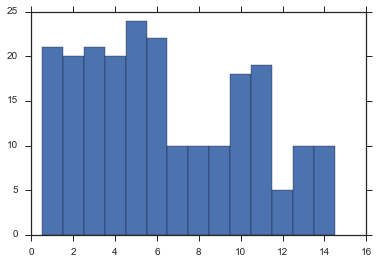

In [5]:
for sub in range(1, 15):
    try:
        nsession = len(events.xs('S%02i'%sub, level='subject').groupby(level=['session', 'block']))
        bar(sub-0.5, nsession, 1)
    except Exception as e :
        print e

In [ ]:
for sub in range(1, 16):
    num_blocks = sum([len(k) for _, k in events[events.snum==sub].groupby()])

The data
--------

The next plot shows the raw pupil data across all available blocks for S2. The shown data has been band pass filtered in a range of [0.01 and 10] Hz.

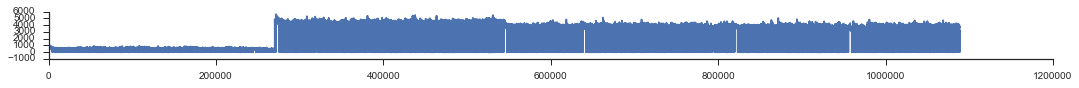

In [12]:
figure(figsize=(18,12))
for i, (snum, sdata) in enumerate(events.groupby(level='subject')):
    subplot(12, 1, i+1)
    plot(sdata.pa.values)
    #ylim(-5, 5)
    
sns.despine()
#xlim([295000, 300000])
#ylim([-2.5, 2.5])

In [13]:
events = events.groupby(level='session').apply(pupil.cleanup)


In [18]:
 287231/5./100

574.462

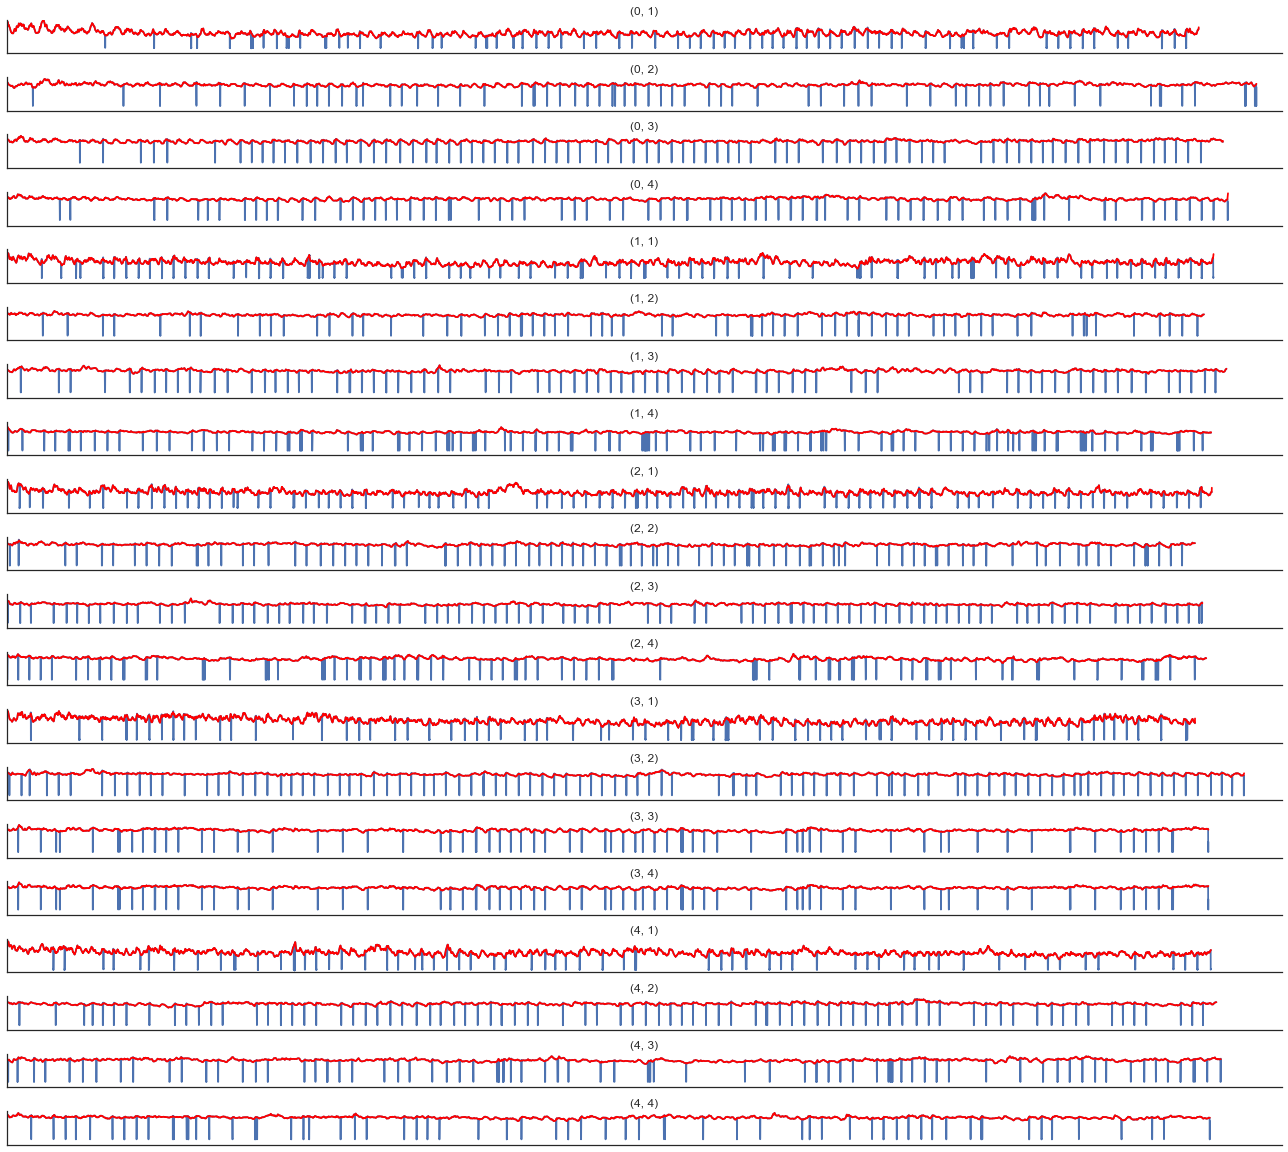

In [17]:
figure(figsize=(18,12*5))
for i, (snum, sdata) in enumerate(events.groupby(level=['block', 'session'])):
    subplot(15*5, 1, i+1)
    t = arange(len(sdata))
    plot(t, sdata.pa.values)
    plot(t, sdata.pac.values, 'r')
    #ylim(-5, 5)
    yticks([])
    xticks([])
    xlim([0, 287231/5.])
    title(snum)
sns.despine()
tight_layout()
#ylim([-2.5, 2.5])

In [ ]:
def zscore(ev):
    ev['pac'] = (ev.pac - ev.pac.mean())/ev.pac.std()
    return ev
events = events.groupby(level='session').apply(zscore)

In [ ]:
figure(figsize=(18,3))
t = arange(len(events))/100.
plot(t, events.pac.values)
sns.despine()

#ylim([-2.5, 2.5])

The Model
---------

I use a simple GLM and convolve regressors with JW's standard IRF. I first compute the convolution kernels and then add some event fields that are useful for the model.

In [ ]:
import pupil
yI, ydtI, ydnI = pupil.IRF_pupil()
IRFS = [yI/yI.std(), ydnI/ydnI.std(), ydtI/ydtI.std()]
yIe, ydtIe, ydnIe = pupil.IRF_pupil(tmax=0.25, n=1)#tmax=.25, n=8)
IRFSe = [yIe, ydtIe, ydnIe]

In [ ]:
low, pa , above = pupil.filter_pupil(events.pa, 100, highcut=10, lowcut=0.1)
figure(figsize=(20, 6))
plot(pa)
low, pa, above = pupil.filter_pupil(events.pa, 100, highcut=10, lowcut=1/(6.))
plot(pa)
xlim([50000, 70000])

In [ ]:
events['pafilt'] = pa

# Full GLM

In [ ]:
events['decend'] = events.decision>0

m, yh, y, X, res = pupil.eval_model('''
pafilt ~   
     pt.Z(left_gx) +pt.Z(left_gy) +
     pt.MF(pt.Z(left_gx), IRFS) + 
     pt.MF(pt.Z(left_gy), IRFS) + 
     pt.MF(blink, IRFS) +
     pt.MF(pt.Z(pt.dt(left_gx)), IRFS) + 
     pt.MF(pt.Z(pt.dt(left_gy)), IRFS) +
     
     pt.MF(ref, func=IRFS) +  
     pt.MF(contrast, func=IRFS) +
     pt.MF(pt.Z(pt.dt(contrast)), func=IRFS) +
     
     pt.MF(decramp21, IRFS) +
     pt.MF(decramp22, IRFS) +
     pt.MF(decramp23, IRFS) +
     pt.MF(decramp24, IRFS) +

     pt.MF(dec_start, IRFS) +
     pt.MF(decend, IRFS) +     
     
     pt.MF(feedback_offset_pos, IRFS) +
     pt.MF(feedback_offset_neg, IRFS) 
''', events.reset_index())
print events.shape
print yh.shape
events['yhat'] = yh
events['residuals'] = y-yh


In [ ]:
import glm_viz
figure(figsize=(20, 6))
glm_viz.timecourse(events, y, yh, [2000, 2100])

In [ ]:
messages['contrast_onset_time'] = [x.contrast_time[0] for _,x in messages.iterrows()]
messages['reference_onset_time'] = [x.decision_time-1900 for _, x in messages.iterrows()]

In [ ]:
figure(figsize=(20,8))
glm_viz.condition_averages(events, messages)

In [ ]:
t = linspace(0, 1, 100)
plot(1/t, t)

In [ ]:
xvals = events.pafilt-events.yhat
print xvals.shape

In [ ]:
xcorr = correlate(xvals[::2], xvals[::2], 'same')

In [ ]:
print xcorr.shape
plot((arange(len(xcorr))-len(xcorr)/2.)/50., xcorr)
xlim([-200, 200])